In [1]:
import pandas as pd
import jieba
import re
import matplotlib
import matplotlib.pyplot as plt
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
import pyLDAvis.gensim_models
import numpy as np

from pymongo import MongoClient
import pymongo

In [2]:
# 使用GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
! nvidia-smi

Thu Jun 23 14:42:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 47%   59C    P2    73W / 260W |   3044MiB / 11019MiB |     29%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 28%   

# LDA

## 2020 brief paragraph

In [3]:
file_us = open("../LDA/segment/data/us_file_brief_paragraph_2020.txt", "r")
us_lines = file_us.readlines()

# file_us = open("../MUSE-main/data/us_file_brief_p_paragraph.txt", "r")
# us_lines = file_us.readlines()

In [4]:
us_desc = [i.replace(" \n","").split(" ") for i in us_lines]
# us_desc = [i.replace(" \n","").split(" ") for i in us_lines]

In [5]:
id2word = corpora.Dictionary(us_desc)
print('資料集字典：')
print(id2word)

資料集字典：
Dictionary(10545 unique tokens: ['action', 'apparatus', 'base', 'channel', 'ci']...)


In [6]:
corpus = [id2word.doc2bow(text) for text in us_desc]
print('第一篇文章 corpus :')
print(corpus[0][:10])

第一篇文章 corpus :
[(0, 1), (1, 1), (2, 3), (3, 5), (4, 2), (5, 1), (6, 3), (7, 2), (8, 1), (9, 1)]


+ corpus = 文檔語料庫
+ id2word = 詞彙字典
+ num_topics = 生成幾個主題數
+ random_state = 固定亂數值，每次的模型結果會一樣
+ iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
+ passes(epoch) = 整個 corpus 訓練模型的次數
+ alpha = 文章主題分佈
+ eta = 主題字分佈

In [7]:
topic_num_list = np.arange(2, 26, 1)
result = []
for topic_num in topic_num_list:
    # perplexity
    tmp_ldamodel = gensim.models.ldamulticore.LdaMulticore(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=id2word,
        random_state = 1500,
        passes=5,
        iterations=2000
        )
    tmp_perplexity = tmp_ldamodel.log_perplexity(corpus)
    temp_skleran = np.exp(-1. * tmp_perplexity)
    
    result.append({"topic_num": topic_num, "gensim_perplexity": tmp_perplexity, "perplexity":temp_skleran})
    print(topic_num)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


,topic_num,gensim_perplexity,perplexity
0,2,-6.555962,703.425767
1,3,-6.567548,711.622574
2,4,-6.547612,697.576562
3,5,-6.532603,687.184562
4,6,-6.520689,679.045898
5,7,-6.536658,689.976506
6,8,-6.517023,676.561094
7,9,-6.511542,672.863099
8,10,-6.502838,667.031719
9,11,-6.505687,668.935353


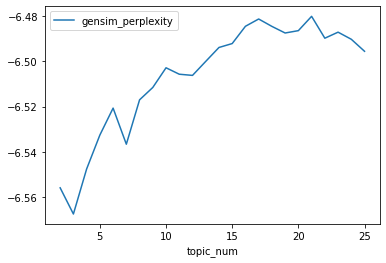

In [8]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='gensim_perplexity', label='gensim_perplexity')
result

,topic_num,gensim_perplexity,perplexity
0,2,-6.555962,703.425767
1,3,-6.567548,711.622574
2,4,-6.547612,697.576562
3,5,-6.532603,687.184562
4,6,-6.520689,679.045898
5,7,-6.536658,689.976506
6,8,-6.517023,676.561094
7,9,-6.511542,672.863099
8,10,-6.502838,667.031719
9,11,-6.505687,668.935353


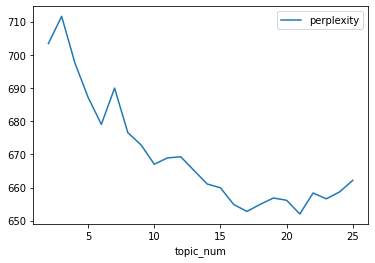

In [9]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='perplexity', label='perplexity')
result

In [10]:
# 儲存LDA_result
result.to_csv("./result/LDA_us_brief_paragraph_2020.csv", index=False)

## priority description sentence

In [27]:
# file_us = open("../MUSE-main/data/us_file_desc_p_s_2500.txt", "r")
# us_lines = file_us.readlines()

# file_us = open("../MUSE-main/data/us_file_desc_p_s_2500.txt", "r")
# us_lines = file_us.readlines()

In [28]:
# us_desc = [i.replace(" \n","").split(" ") for i in us_lines]
# us_desc = [i.replace(" \n","").split(" ") for i in us_lines]

In [29]:
# id2word = corpora.Dictionary(us_desc)
# print('資料集字典：')
# print(id2word)

資料集字典：
Dictionary(67064 unique tokens: ['以及', '传感器', '信息', '平台', '应用']...)


In [30]:
# corpus = [id2word.doc2bow(text) for text in us_desc]
# print('第一篇文章 corpus :')
# print(corpus[0][:10])

第一篇文章 corpus :
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]


+ corpus = 文檔語料庫
+ id2word = 詞彙字典
+ num_topics = 生成幾個主題數
+ random_state = 固定亂數值，每次的模型結果會一樣
+ iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
+ passes(epoch) = 整個 corpus 訓練模型的次數
+ alpha = 文章主題分佈
+ eta = 主題字分佈

In [32]:
# topic_num_list = np.arange(2, 20, 2)
# result = []
# for topic_num in topic_num_list:
#     # perplexity
#     tmp_ldamodel = gensim.models.ldamulticore.LdaMulticore(
#         corpus = corpus,
#         num_topics = topic_num ,
#         id2word=id2word,
#         random_state = 1500,
#         passes=5,
#         iterations=2000
#         )
#     tmp_perplexity = tmp_ldamodel.log_perplexity(corpus)
#     temp_skleran = np.exp(-1. * tmp_perplexity)
    
#     result.append({"topic_num": topic_num, "gensim_perplexity": tmp_perplexity, "perplexity":temp_skleran})
#     print(topic_num)

KeyboardInterrupt: 

,topic_num,gensim_perplexity,perplexity
0,2,-6.994831,1090.979302
1,4,-6.948481,1041.566721
2,6,-7.001723,1098.524768
3,8,-7.073958,1180.811971
4,10,-7.275728,1444.802642
5,12,-7.520683,1845.827325


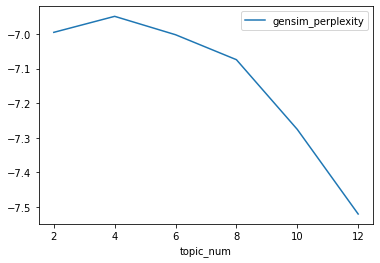

In [33]:
# result = pd.DataFrame(result)
# result.plot.line(x='topic_num', y='gensim_perplexity', label='gensim_perplexity')
# result

,topic_num,gensim_perplexity,perplexity
0,2,-6.994831,1090.979302
1,4,-6.948481,1041.566721
2,6,-7.001723,1098.524768
3,8,-7.073958,1180.811971
4,10,-7.275728,1444.802642
5,12,-7.520683,1845.827325


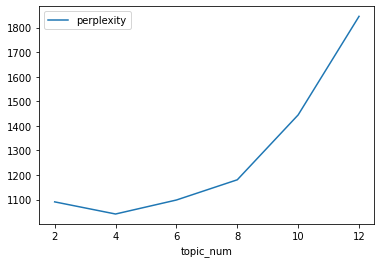

In [34]:
# result = pd.DataFrame(result)
# result.plot.line(x='topic_num', y='perplexity', label='perplexity')
# result

In [15]:
# 儲存LDA_result
# result.to_csv("./result/LDA_us_desc_p_s_2500.csv", index=False)

## 找出文章topic

In [11]:
best_num = result[result.perplexity == min(result.perplexity)]["topic_num"].values[0]

In [12]:
ldamodel = gensim.models.ldamulticore.LdaMulticore(
        corpus = corpus,
        num_topics = best_num ,
        id2word=id2word,
        random_state = 1500,
        passes=5,
        iterations=2000
        )

In [13]:
# 取得每個文章的主題分佈
topics_doc = ldamodel.get_document_topics(corpus, minimum_probability=0.000001) 

In [14]:
c = [i[1] for i in topics_doc[0]]
c.index(max(c)) 

2

In [15]:
topics_us = [] 
for topics in topics_doc:
    c = [i[1] for i in topics]
    topics_us.append(c.index(max(c)))

In [16]:
topics_us

[2,
 17,
 7,
 19,
 7,
 7,
 17,
 1,
 10,
 11,
 18,
 12,
 5,
 14,
 10,
 6,
 7,
 20,
 7,
 7,
 1,
 7,
 1,
 8,
 9,
 13,
 5,
 9,
 17,
 19,
 9,
 7,
 7,
 7,
 6,
 7,
 9,
 7,
 2,
 15,
 5,
 9,
 9,
 8,
 2,
 17,
 13,
 6,
 7,
 7,
 13,
 17,
 7,
 19,
 2,
 9,
 7,
 14,
 17,
 3,
 9,
 6,
 13,
 7,
 8,
 13,
 0,
 20,
 15,
 14,
 10,
 6,
 7,
 19,
 6,
 15,
 10,
 7,
 16,
 9,
 7,
 13,
 12,
 7,
 15,
 2,
 17,
 1,
 5,
 20,
 14,
 5,
 2,
 7,
 18,
 7,
 15,
 17,
 7,
 6,
 10,
 4,
 4,
 17,
 1,
 14,
 7,
 1,
 2,
 10,
 17,
 14,
 7,
 19,
 14,
 15,
 5,
 18,
 10,
 9,
 13,
 15,
 15,
 3,
 5,
 17,
 6,
 7,
 13,
 7,
 5,
 0,
 11,
 15,
 5,
 7,
 7,
 0,
 1,
 7,
 18,
 10,
 12,
 14,
 10,
 6,
 8,
 10,
 12,
 7,
 6,
 7,
 18,
 7,
 7,
 1,
 19,
 12,
 8,
 18,
 20,
 8,
 6,
 15,
 9,
 20,
 17,
 7,
 3,
 9,
 5,
 0,
 13,
 11,
 13,
 7,
 3,
 9,
 6,
 7,
 20,
 10,
 7,
 20,
 7,
 16,
 7,
 10,
 19,
 7,
 7,
 7,
 6,
 3,
 2,
 11,
 16,
 7,
 4,
 20,
 20,
 6,
 7,
 19,
 7,
 13,
 6,
 6,
 6,
 7,
 9,
 3,
 5,
 17,
 7,
 7,
 9,
 7,
 7,
 9,
 15,
 6,
 7,
 10,
 10,
 15,
 19

In [17]:
print(len(topics_us))
print(len(us_desc))

8455
8455


## 找出對應的patent編號和公司

In [18]:
mongoURI = "mongodb://%s:%s@%s/%s?authMechanism=SCRAM-SHA-1" % ("eva", "eva_30241", "140.117.69.70:30241", "eva")

try:
    conn = pymongo.MongoClient(mongoURI)
    db = conn.eva
    # db_rm_us = db.rm_patent_us
    # db_rm_us = db.rm_patent_us
    # db_rm_de = db.rm_patent_de
    
    # db_rm_us_2020 = db.rm_patent_us_2020
    db_rm_us_2020 = db.rm_patent_us_2020
    # db_rm_de_2020 = db.rm_patent_de_2020
except errors.ConnectionFailure as err:
    print(err)

In [19]:
# data_us_desc = p_db_us.find({}, {"patentNumber":1, "brief": 1})
data_us_desc = db_rm_us_2020.find({}, {"patentNumber":1, "brief": 1, "current_assignee":1})

ls_id = []
ls_pNo = []
ls_com = []
ls_desc = []
for data in data_us_desc:
    # print(data["_id"],data["count"])
    ls_id.append(data["_id"])
    ls_pNo.append(data["patentNumber"])
    ls_com.append(data["current_assignee"])
    ls_desc.append(data["brief"])
    

In [20]:
# df_us = pd.DataFrame((zip(ls_id, ls_pNo, ls_desc)), columns = ['id', 'patentNumber', 'brief'])
df_us = pd.DataFrame((zip(ls_id, ls_pNo, ls_com, ls_desc)), columns = ['id', 'patentNumber', 'company', 'brief'])

In [21]:
df_us

,id,patentNumber,company,brief
0,6200e2f77b73c16636b313e4,US20200202117A1,[],"Methods, apparatus and systems for wireless ga..."
1,6200ea237b73c16636b3142a,US20210050104A1,[],A comprehensive health care data management sy...
2,6200ed6d7b73c16636b3144a,US11006920B2,[Netspective Communications LLC],Controlling a multi-device module includes a p...
3,6200fcbb7b73c16636b314fc,US11082218B2,"[M2M AND IOT TECHNOLOGIES LLC, Network 1 Techn...",A module with an embedded universal integrated...
4,620100797b73c16636b31520,US20200358827A1,[Zscaler Inc],"The present disclosure includes, responsive to..."
...,...,...,...,...
8450,620b2c70e0ec9a30af2b76c5,US20210111835A1,[Qualcomm Inc],"The disclosure relates to methods, devices, an..."
8451,620b2c9fe0ec9a30af2b76c7,US11151388B2,[7 Eleven Inc],"An apparatus includes an interface, display, m..."
8452,620b2ca1e0ec9a30af2b76c9,US20210063274A1,[Exfo Inc],"There is therefore provided a method, system a..."
8453,620b2ca2e0ec9a30af2b76cb,US20210141417A1,[Samsung Display Co Ltd],A display device includes a first non-folding ...


In [22]:
print(len(df_us))
print(len(us_desc))

8455
8455


In [23]:
df_us["topic"]=topics_us

In [24]:
df_us

,id,patentNumber,company,brief,topic
0,6200e2f77b73c16636b313e4,US20200202117A1,[],"Methods, apparatus and systems for wireless ga...",2
1,6200ea237b73c16636b3142a,US20210050104A1,[],A comprehensive health care data management sy...,17
2,6200ed6d7b73c16636b3144a,US11006920B2,[Netspective Communications LLC],Controlling a multi-device module includes a p...,7
3,6200fcbb7b73c16636b314fc,US11082218B2,"[M2M AND IOT TECHNOLOGIES LLC, Network 1 Techn...",A module with an embedded universal integrated...,19
4,620100797b73c16636b31520,US20200358827A1,[Zscaler Inc],"The present disclosure includes, responsive to...",7
...,...,...,...,...,...
8450,620b2c70e0ec9a30af2b76c5,US20210111835A1,[Qualcomm Inc],"The disclosure relates to methods, devices, an...",15
8451,620b2c9fe0ec9a30af2b76c7,US11151388B2,[7 Eleven Inc],"An apparatus includes an interface, display, m...",8
8452,620b2ca1e0ec9a30af2b76c9,US20210063274A1,[Exfo Inc],"There is therefore provided a method, system a...",18
8453,620b2ca2e0ec9a30af2b76cb,US20210141417A1,[Samsung Display Co Ltd],A display device includes a first non-folding ...,8


In [25]:
df_us2 = df_us.explode('company')
df_us2

,id,patentNumber,company,brief,topic
0,6200e2f77b73c16636b313e4,US20200202117A1,NaN,"Methods, apparatus and systems for wireless ga...",2
1,6200ea237b73c16636b3142a,US20210050104A1,NaN,A comprehensive health care data management sy...,17
2,6200ed6d7b73c16636b3144a,US11006920B2,Netspective Communications LLC,Controlling a multi-device module includes a p...,7
3,6200fcbb7b73c16636b314fc,US11082218B2,M2M AND IOT TECHNOLOGIES LLC,A module with an embedded universal integrated...,19
3,6200fcbb7b73c16636b314fc,US11082218B2,Network 1 Technologies Inc,A module with an embedded universal integrated...,19
...,...,...,...,...,...
8450,620b2c70e0ec9a30af2b76c5,US20210111835A1,Qualcomm Inc,"The disclosure relates to methods, devices, an...",15
8451,620b2c9fe0ec9a30af2b76c7,US11151388B2,7 Eleven Inc,"An apparatus includes an interface, display, m...",8
8452,620b2ca1e0ec9a30af2b76c9,US20210063274A1,Exfo Inc,"There is therefore provided a method, system a...",18
8453,620b2ca2e0ec9a30af2b76cb,US20210141417A1,Samsung Display Co Ltd,A display device includes a first non-folding ...,8


In [26]:
# 排名前16的公司
c_ls = list(df_us2.groupby("company",as_index=False).size().sort_values("size",ascending=False).head(16).company)
c_ls

['Qualcomm Inc',
 'Samsung Electronics Co Ltd',
 'Intel Corp',
 'LG Electronics Inc',
 'International Business Machines Corp',
 'Huawei Technologies Co Ltd',
 'Micron Technology Inc',
 'AT&T Intellectual Property I LP',
 'Cisco Technology Inc',
 'Verizon Patent and Licensing Inc',
 'Microsoft Technology Licensing LLC',
 'T Mobile USA Inc',
 'Shanghai Langbo Communication Technology Co Ltd',
 'Nokia Technologies Oy',
 'EMC Corp',
 'Telefonaktiebolaget LM Ericsson AB']

### 轉成company-topic 的總數表格

In [27]:
df_us_count = df_us2.groupby(["company","topic"],as_index=False).size()
df_us_count

,company,topic,size
0,#glowontech,0,1
1,10353744 Canada Ltd,7,1
2,151 Research Inc,8,1
3,2524726 Ontario Inc,2,1
4,3M Innovative Properties Co,12,1
...,...,...,...
2877,Zurn Industries LLC,7,1
2878,comScore Inc,7,1
2879,eBay Inc,7,1
2880,fybr,7,1


In [28]:
# 轉成company-topic 的總數表格
table_us = df_us_count.pivot_table(index='company', values='size', columns='topic',aggfunc=['sum']).fillna(0).reset_index()
table_us = table_us.droplevel(level=0, axis=1)
table_us = table_us.rename(columns={'':'company'})

In [29]:
table_us

topic,company,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,16,17,18,19,20
0,#glowontech,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10353744 Canada Ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,151 Research Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2524726 Ontario Inc,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3M Innovative Properties Co,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1450,Zurn Industries LLC,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1451,comScore Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1452,eBay Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1453,fybr,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
final_table_us = table_us[table_us.company.isin(c_ls)]
final_table_us

topic,company,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,16,17,18,19,20
17,AT&T Intellectual Property I LP,1.0,13.0,4.0,8.0,3.0,3.0,5.0,31.0,4.0,...,1.0,2.0,13.0,2.0,11.0,1.0,18.0,3.0,8.0,0.0
253,Cisco Technology Inc,1.0,7.0,2.0,17.0,3.0,1.0,4.0,43.0,7.0,...,2.0,3.0,20.0,0.0,1.0,2.0,8.0,2.0,8.0,2.0
375,EMC Corp,1.0,0.0,1.0,1.0,0.0,3.0,0.0,16.0,0.0,...,1.0,0.0,13.0,0.0,1.0,1.0,2.0,2.0,6.0,1.0
537,Huawei Technologies Co Ltd,0.0,27.0,0.0,6.0,7.0,7.0,3.0,20.0,10.0,...,16.0,6.0,2.0,2.0,32.0,9.0,24.0,2.0,5.0,0.0
591,Intel Corp,3.0,51.0,9.0,15.0,2.0,13.0,12.0,54.0,18.0,...,9.0,19.0,20.0,6.0,32.0,17.0,18.0,4.0,16.0,13.0
597,International Business Machines Corp,2.0,0.0,2.0,7.0,3.0,13.0,4.0,43.0,5.0,...,5.0,4.0,37.0,3.0,2.0,12.0,2.0,13.0,14.0,9.0
673,LG Electronics Inc,3.0,23.0,6.0,5.0,48.0,8.0,22.0,6.0,16.0,...,7.0,7.0,8.0,0.0,76.0,3.0,9.0,8.0,3.0,6.0
771,Micron Technology Inc,3.0,1.0,2.0,8.0,0.0,2.0,9.0,20.0,2.0,...,1.0,29.0,5.0,1.0,0.0,0.0,11.0,1.0,14.0,5.0
772,Microsoft Technology Licensing LLC,1.0,2.0,0.0,8.0,1.0,3.0,8.0,15.0,3.0,...,3.0,1.0,17.0,1.0,2.0,7.0,4.0,3.0,5.0,5.0
855,Nokia Technologies Oy,0.0,8.0,0.0,3.0,3.0,3.0,4.0,6.0,6.0,...,5.0,1.0,2.0,0.0,10.0,1.0,4.0,0.0,0.0,0.0


In [31]:
final_table_us.shape

(16, 22)

In [32]:
table_us.to_csv('company_lda_brief_us_2020.csv',index=0)